<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_Scratch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from os import listdir
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
import tensorflow as tf 

In [0]:
print(tf.__version__)

In [0]:
import keras as ks 

Using TensorFlow backend.


In [0]:
print(ks.__version__)

# import the necessary packages


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow



In [0]:
from google.colab import files
files.upload() 

Saving createimagedataset.py to createimagedataset.py


{'createimagedataset.py': b'# -*- coding: utf-8 -*-\n"""createImageDataset.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1FXiYKCQ-jtbL_O29BQb2Xy1bBd2inM9q\n"""\n\nfrom os import listdir\nimport numpy as np\nimport xml.etree.ElementTree as ET\nimport cv2\nfrom google.colab.patches import cv2_imshow\n\nclass createImageDataset(object):\n    \n    def __init__(self, class_map=None):\n        self.image_info = []\n        self.trainX = []\n        self.trainY = []\n        self.testX = []\n        self.testY = []\n            \n    def add_image_info(self , image_array , image_path , image_id , object_id , class_name , class_id):\n        \n        image_info_ = {\'object_id\': image_id,\n                       \'object_class\': class_name,\n                       \'image_path\': image_path,\n                       \'image_array\': image_array,\n                       \'class_id\' : class_id}\n        self.imag

In [0]:
import createimagedataset as dataset

In [0]:
file_list = drive.ListFile(
    {'q': "'1RSwoFiYQXzwgRhR7HHlJ5TYRATyfXBai' in parents"}).GetList()

for f in file_list:
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = f['title']
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

title: LABELS.zip, id: 1KsW4XPz3Kcy8s1HfKEBqob48snm3AfiN
downloading to LABELS.zip
title: GREENPATROL_DB_V1.0.zip, id: 1IrF6nrEx7NUZ9kNFsuWZdLJgTRPHwg2F
downloading to GREENPATROL_DB_V1.0.zip
title: Untitled0.ipynb, id: 1VBu-bhwXGKUz_Ew25RH6VRzZD3IzN-BF
downloading to Untitled0.ipynb
title: predefined_classes.txt, id: 1O-dBOm30GdQn2m0C_5QCqrjWZAAhpPic
downloading to predefined_classes.txt
title: all_pictures.txt, id: 1lPM9fmGp_fmwzjUK4vjG6mUytjC7cFFw
downloading to all_pictures.txt


In [0]:
download_Pests = drive.CreateFile({'id': '1IrF6nrEx7NUZ9kNFsuWZdLJgTRPHwg2F'})


In [0]:
download_Annotations = drive.CreateFile({'id': '1KsW4XPz3Kcy8s1HfKEBqob48snm3AfiN'})


In [0]:
!unzip LABELS.zip -d '/Pests'


In [0]:
!unzip GREENPATROL_DB_V1.0.zip -d '/Pests'


# Data PreProcessing and Transformation 

In [0]:
i = '1_2_2_6_1_1_20180622-102849.xml'

In [0]:
            img = cv2.imread('/Pests/GREENPATROL_DB_V1.0/'+i[0:-4]+'.jpg')


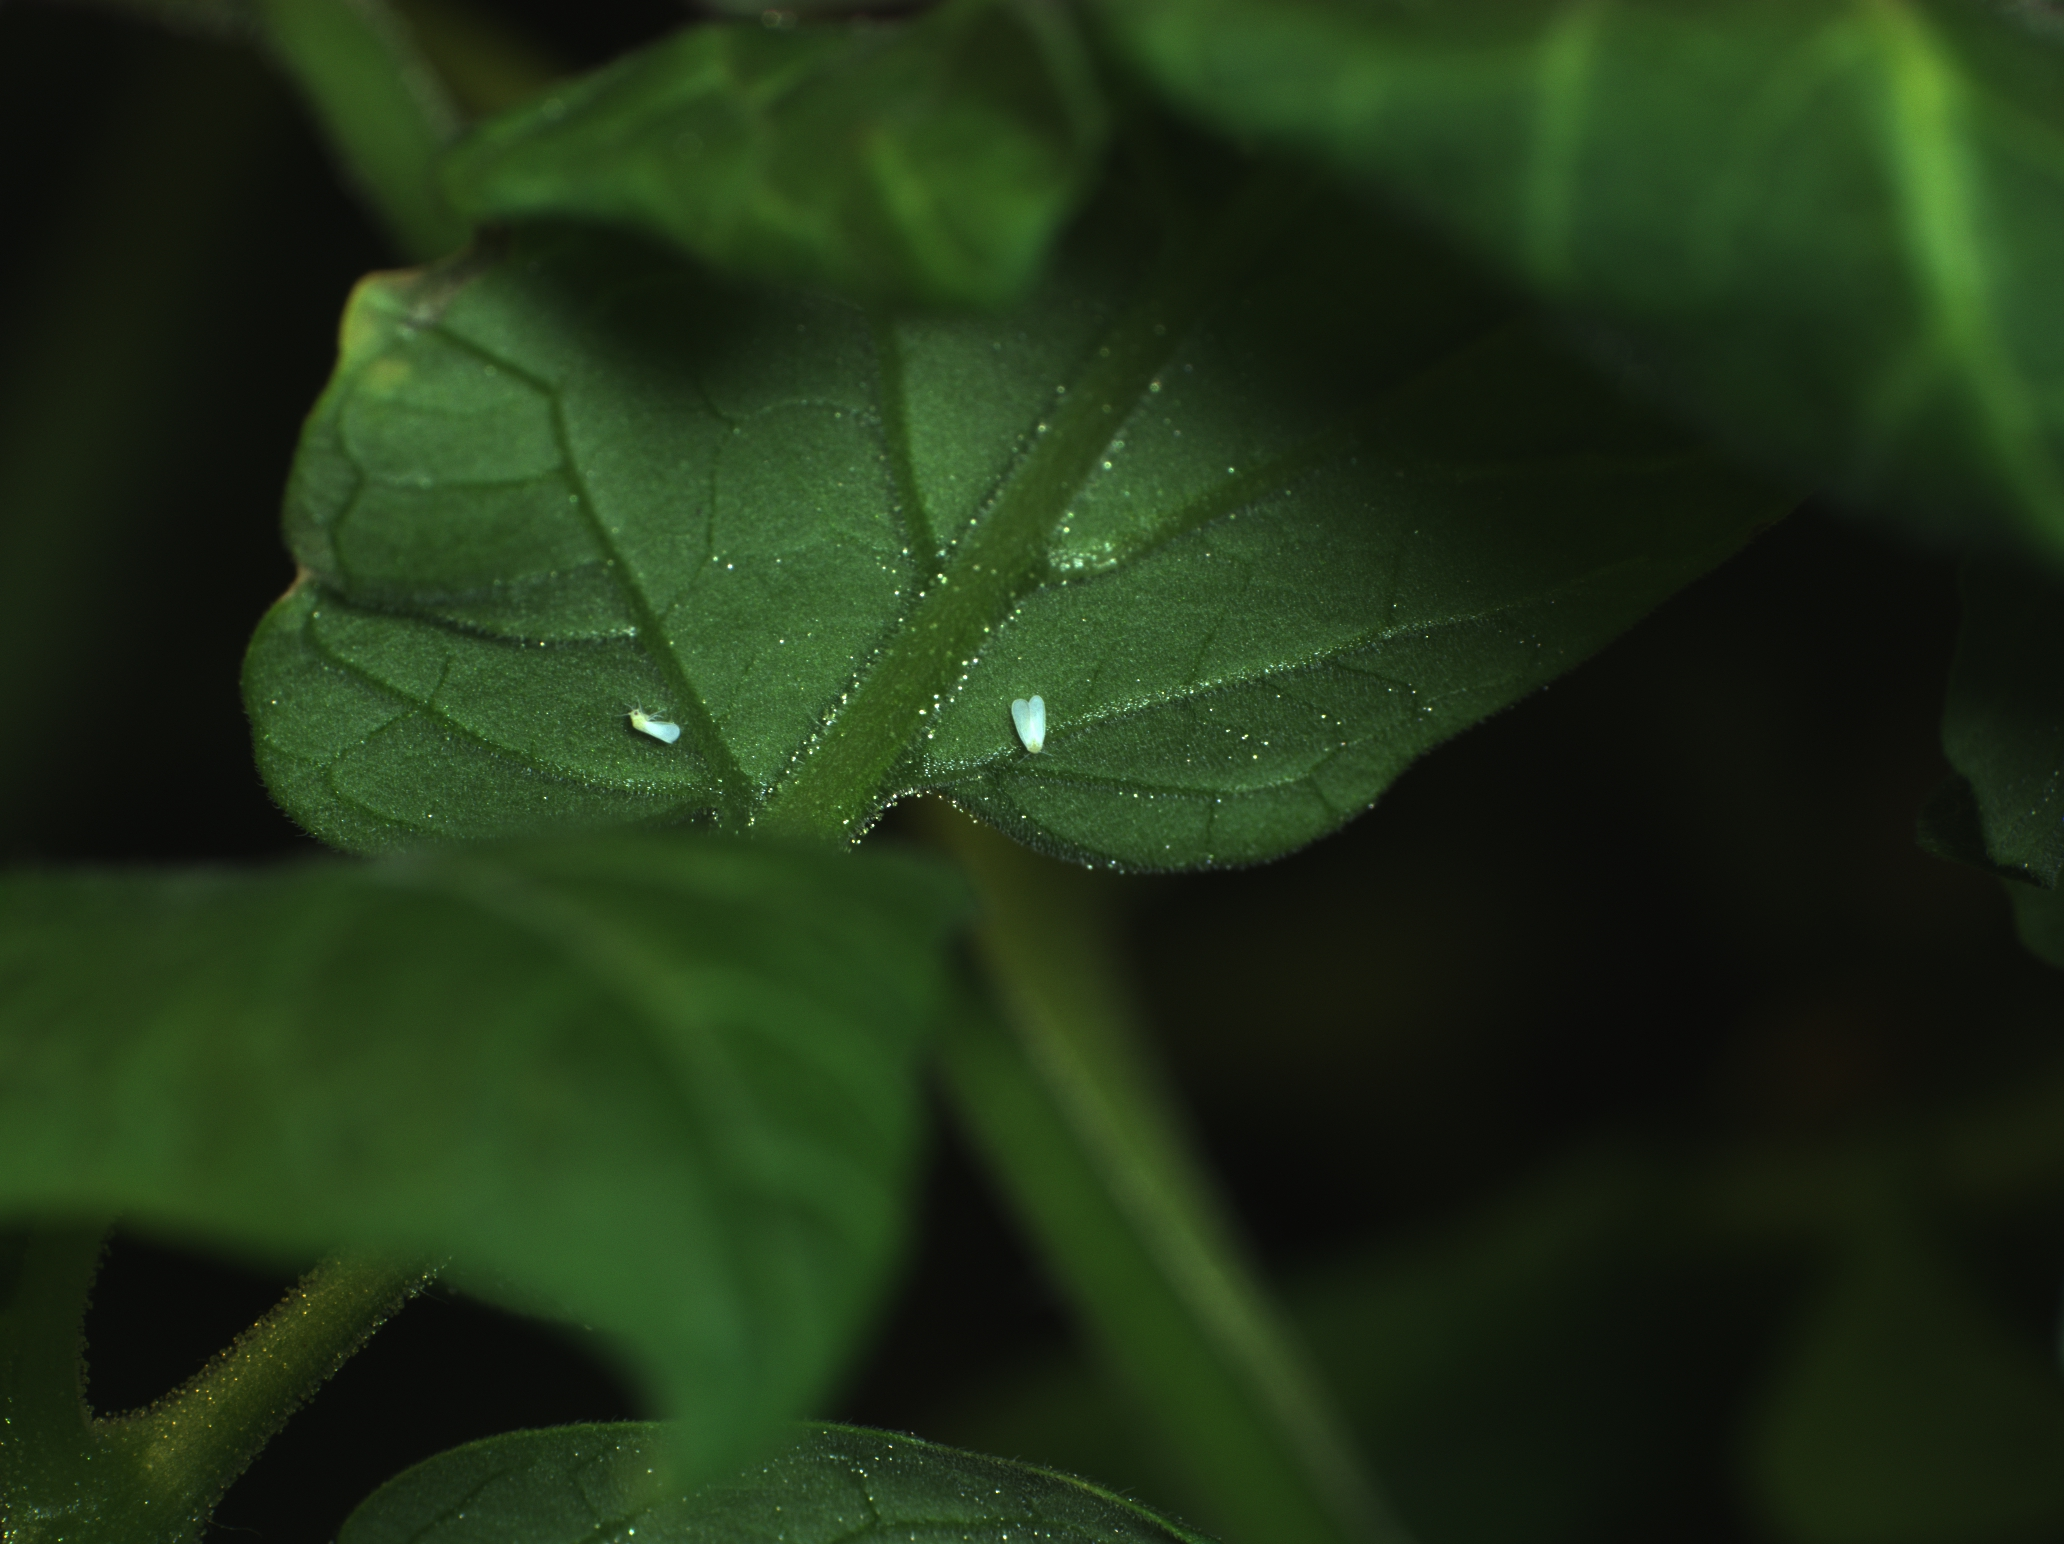

In [0]:
cv2_imshow(img)
#cv2.waitKey(0)



In [0]:
class_object = {0 : 'background' , 1 : 'egg_wf' ,
                2 : 'egg_bt', 3 : 'egg_ta', 4 : 'wf', 5 : 'bt', 6 : 'ta', 7 : 'ta_maps', 8 : 'ta_larvae', 9 : 'ta_maps+larvae', 10 : 'tomato'}

In [0]:
# -*- coding: utf-8 -*-
"""createImageDataset.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1FXiYKCQ-jtbL_O29BQb2Xy1bBd2inM9q
"""

from os import listdir
import numpy as np
import xml.etree.ElementTree as ET
import cv2
from google.colab.patches import cv2_imshow

class createImageDataset(object):
    
    def __init__(self, class_map=None):
        self.image_info = []
        self.trainX = []
        self.trainY = []
        self.testX = []
        self.testY = []
            
    def add_image_info(self , image_array , image_path , image_id , object_id , class_name , class_id):
        
        image_info_ = {'object_id': image_id,
                       'object_class': class_name,
                       'image_path': image_path,
                       'image_array': image_array,
                       'class_id' : class_id}
        self.image_info.append(image_info_)

    def parse_xml(self,filer):
        boxes = list()
        names = list()
        root = ET.parse(filer).getroot() 
        for box in root.findall('.//object'):
            xmin = int(box.find('.//bndbox/xmin').text)
            xmax = int(box.find('.//bndbox/xmax').text)
            ymin = int(box.find('.//bndbox/ymin').text)
            ymax = int(box.find('.//bndbox/ymax').text)
            name = root.find('.//name').text
            coords = [xmin , ymin , xmax , ymax]
            names.append(name)
            boxes.append(coords)
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        path = root.find('.//path').text
        filename = root.find('filename').text
        filename = filename[:-4]

        return boxes, width, height , names , path , filename

    def get_image_arrays(self , annot_path , class_object):
        
        count = 0
        limit = 0
        for i in listdir(annot_path):
            patt = annot_path +'/' + i
            parsed = self.parse_xml(patt)
            img = cv2.imread('/Pests/GREENPATROL_DB_V1.0/'+i[0:-4]+'.jpg')
            for wh in range(0 , len(parsed[0])):
                crop_img = img[parsed[0][wh][1]:parsed[0][wh][3] , parsed[0][wh][0]:parsed[0][wh][2] ]
                
                class_name = parsed[3][wh]
                keys = list(class_object.keys())  
                values = list(class_object.values())
                class_id = keys[values.index(class_name)]
                
                resized_img = cv2.resize(crop_img,(32,32))
                while limit < 9:
                 cv2_imshow(resized_img)
                self.add_image_info( image_array = resized_img , image_path = parsed[4],
                                   object_id = count , class_name=parsed[3][wh] , image_id= 0 , class_id=class_id )
                print('İmage : ' + parsed[4] + ' added to dataset with class name "' + parsed[3][wh]  +'".'  )
                count = count + 1
                limit = limit + 1  
    def prepare_dataset(self , path , class_object , test_size):
        
        self.get_image_arrays(path , class_object)
        
        img_arrays = np.array([d['image_array'] for d in self.image_info if 'image_array' in d])
        class_names = np.array([d['object_class'] for d in self.image_info if 'object_class' in d])
        class_ids  = np.array([d['class_id'] for d in self.image_info if 'class_id' in d])
        all_idx = range(0 , len(img_arrays))
        test_idx = np.random.choice(np.arange(len(img_arrays)), test_size, replace=False)
        train_idx = np.delete(all_idx , test_idx) 
        
        
        self.testX = img_arrays[test_idx]
        self.testY = class_ids[test_idx]
        
        self.trainX = img_arrays[train_idx]        
        self.trainY = class_ids[train_idx]

        #trainX = img_arrays
        #trainY = class_ids
        
        return print('Image dataset succesfully saved.')

In [0]:
 v = createImageDataset()

In [0]:
dataSet = v.prepare_dataset('/Pests/LABELS' , class_object,   test_size=30)

In [0]:
(trainY , trainX) , (testY , testX ) = (train_set.trainY , train_set.trainX ) , (train_set.testY , train_set.testX )



In [0]:
print(testX.size)

92160
